In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import struct
from scipy.signal import spectrogram, stft
import scipy.stats
from scipy.stats import entropy, ttest_ind, wilcoxon, mannwhitneyu, kruskal, f_oneway, shapiro
import numpy as np
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import math
from tqdm import tqdm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import gc

import pickle as pkl

import seaborn as sns
sns.set_style(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

import glob

gc.enable()

%matplotlib inline

# Functions

In [2]:
#### Функция для считывания аудиофайлов с возможностью накладывать один на другой ####

def read_audio(path_1, path_2=None, sr=192000, w1=1, w2=0):
    
    x1 , _ = librosa.load(path_1, sr=sr)
    
    length = x1.size
    
    if path_2 is not None:
        x2 , _ = librosa.load(path_2, sr=sr)
        length = min(x1.size, x2.size)
        
        return w1*x1[:length] + w2*x2[:length]
        
    return w1*x1[:length]

In [3]:
#### Функция для считывания бинарников ####

def read_bin(path):
    N = 0
    time_freq = []
    with open(path, 'rb') as f:
        byte = f.read(4)
        while byte:
            nodes = int.from_bytes(byte, "big")
            time_freq.append([])
            time = []
            freq = []
            for n in range(nodes*2):
                if n % 2 == 0:
                    freq.append(struct.unpack('d', f.read(8)[::-1])[0])
                else:
                    time.append(struct.unpack('d', f.read(8)[::-1])[0])
            time_freq[-1].append([time, freq])
            byte = f.read(4)
            N += 1
    return time_freq

In [4]:
#### Функция для проецирования исходной разметки на нашу сетку ####

def get_labels(freqs, times, label_freq_arr, label_time_arr, label_window_size=50):
    
    f_min = np.min(label_freq_arr)
    f_max = np.max(label_freq_arr)
    freq_ind_min = max(np.argmax(freqs[freqs <= f_min]) - label_window_size, 0)
    freq_ind_max = min(np.argmax(freqs[freqs < f_max]) + 1 + label_window_size, freqs.size-1)
    
    t_min = np.min(label_time_arr)
    t_max = np.max(label_time_arr)
    time_ind_min = max(np.argmax(times[times <= t_min]) - label_window_size, 0)
    time_ind_max = min(np.argmax(times[times < t_max]) + 1 + label_window_size, times.size-1)

    XX = np.zeros((len(times[time_ind_min:time_ind_max])*len(freqs[freq_ind_min:freq_ind_max]), 2))
    YY = np.array(list(zip(label_time_arr, label_freq_arr)))
    k = 0
    for t in times[time_ind_min:time_ind_max]:
        for f in freqs[freq_ind_min:freq_ind_max]:
            XX[k, 0] = t
            XX[k, 1] = f
            k += 1

    vals = XX[np.argmin(pairwise_distances(XX, YY, metric='euclidean'), axis=0)]
    
    return np.unique(vals, axis=0), freq_ind_min, freq_ind_max, time_ind_min, time_ind_max

In [110]:
#### Функция для отделения сигнала и шума первым способом ####

def signal_noise_derive_1(freqs, times, Xdb, time_freq, signal_points, time_noise_points, freq_min, freq_max):
    
    #### help funcs for deriving indexes of values from time and freq arrays ####
    
    def time_val_to_inds(val, arr_of_vals=times, width=signal_points):
        val_ind = np.argwhere(arr_of_vals==val)[0,0]
        
        return [max(i, 0) for i in range(val_ind-width, val_ind, 1)] + [min(i, arr_of_vals.size-1) for i in range(val_ind, val_ind+width+1, 1)]

    def freq_val_to_inds(val, arr_of_vals=freqs, width=signal_points):
        val_ind = np.argwhere(arr_of_vals==val)[0,0]
    
        return [val_ind for i in range(val_ind-width, val_ind+width+1, 1)]

    #### Main body of method ####
    
    X_signal = np.zeros(Xdb.shape)
    X_noise = np.copy(Xdb)
    
    freq_time_target_inds_array = []
    k_arr = []
    
    for k in tqdm(range(len(time_freq)), position=0):
        
        freq_target_inds = []
        time_target_inds = []
        
        our_labels, _, _, _, _ = get_labels(freqs, 
                                            times, 
                                            time_freq[k][0][0], 
                                            time_freq[k][0][1],
                                            5)
        
        freq_target_inds = list(map(freq_val_to_inds, our_labels[:,1]))
        time_target_inds = list(map(time_val_to_inds, our_labels[:,0]))
                            
        
        X_signal[freq_target_inds, time_target_inds] = Xdb[freq_target_inds, time_target_inds]
        X_noise[freq_target_inds, time_target_inds] = -1
        
#         for i in range(our_labels.shape[0]):
            
#             f_ind = np.argwhere(freqs==our_labels[i, 1])[0,0]
#             t_ind = np.argwhere(times==our_labels[i, 0])[0,0]
            
#             temp_time_target_inds = [i for i in range(t_ind-signal_points, t_ind+signal_points+1, 1) if (t_ind+i >= 0) & (t_ind+i <=times.size-1)]
#             time_target_inds += temp_time_target_inds
            
#             freq_target_inds += [f_ind for i in range(len(temp_time_target_inds))]
# #             for i in range(-signal_points, signal_points+1, 1):
# #                 if (t_ind+i >= 0) & (t_ind+i <=times.size-1):
# #                     freq_target_inds.append(f_ind)
# #                     time_target_inds.append(t_ind+i)
                            
#         X_signal[freq_target_inds, time_target_inds] = Xdb[freq_target_inds, time_target_inds]
#         X_noise[freq_target_inds, time_target_inds] = -1
        
        freq_time_target_inds_array.append([freq_target_inds, time_target_inds])
        if np.min(freqs[np.array(freq_target_inds)]) >= freq_min and np.max(freqs[np.array(freq_target_inds)]) <= freq_max:
            k_arr.append(k)
        
    for f_arr, t_arr in tqdm(freq_time_target_inds_array, position=0):
        
        noise_tmp_arr = []
        for j in range(len(f_arr)):
                    
            noise_tmp = X_noise[f_arr[j][0], np.min(t_arr):np.max(t_arr)]
            if np.isnan(noise_tmp[noise_tmp != -1].mean()):
                noise_tmp = X_noise[f_arr[j][0], max(np.min(t_arr)-time_noise_points, 0):min(np.max(t_arr)+time_noise_points, times.size-1)]
            
            mean_noise = noise_tmp[noise_tmp != -1].mean()
            noise_tmp_arr.append([mean_noise for i in range(2*signal_points + 1)])
                
        X_noise[f_arr, t_arr] = noise_tmp_arr
    
    return X_signal, X_noise, freq_time_target_inds_array, k_arr


In [111]:
#### Функция для подсчета СНР ####

def signal_to_noise_ratio(X_signal_windowed, X_noise_windowed):
    P_signal = np.mean(X_signal_windowed, axis=1)
    P_noise = np.mean(X_noise_windowed, axis=1)
    snr = 10*np.log10(P_signal.sum()/P_noise.sum())
    return snr, P_signal, P_noise

In [112]:
#### Функция для подсчета доверительного интервала ####

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

# Testing functions

In [88]:
for file in tqdm(glob.glob('dclmmpa2011-devel-bin/bottlenose/*'), position=0):
    print(file)

100%|██████████| 11/11 [00:00<00:00, 19096.58it/s]

dclmmpa2011-devel-bin/bottlenose/palmyra092007FS192-070924-205730.bin
dclmmpa2011-devel-bin/bottlenose/palmyra092007FS192-071012-010614.bin
dclmmpa2011-devel-bin/bottlenose/palmyra092007FS192-071012-012000.bin
dclmmpa2011-devel-bin/bottlenose/palmyra092007FS192-070924-210000.bin
dclmmpa2011-devel-bin/bottlenose/Qx-Tt-SC03-TAT03-060513-212000.bin
dclmmpa2011-devel-bin/bottlenose/Qx-Tt-SCI0608-Ziph-060819-072558.bin
dclmmpa2011-devel-bin/bottlenose/Qx-Tt-SCI0608-N1-060814-123433.bin
dclmmpa2011-devel-bin/bottlenose/palmyra102006-061030-230343_4.bin
dclmmpa2011-devel-bin/bottlenose/Qx-Tt-SCI0608-Ziph-060819-074737.bin
dclmmpa2011-devel-bin/bottlenose/Qx-Tt-SCI0608-N1-060814-121518.bin
dclmmpa2011-devel-bin/bottlenose/palmyra092007FS192-070924-205305.bin


In [83]:
import warnings
warnings.filterwarnings('ignore')

sr = 192000

n_fft = 4096

signal_points = 2
time_noise_points = 150

freq_min = 8000
freq_max= 11000

k_arr = []
snr_array_local = []

file = 'dclmmpa2011-devel-bin/bottlenose/Qx-Tt-SCI0608-N1-060814-123433.bin'
            
time_freq = read_bin(file)

path_1 = 'data/5th_DCL_data_bottlenose/{0}.wav'.format(file.split('/')[-1].split('.')[0])

x = read_audio(path_1, path_2=None, sr=sr, w1=1, w2=0)

freqs, times, X = stft(x, fs=sr, nperseg=n_fft, noverlap=n_fft/2)
Xdb = X.real**2 + X.imag**2

X_signal, X_noise, freq_time_target_inds_array = signal_noise_derive_1(freqs, times, Xdb, time_freq, signal_points, time_noise_points)

for k in range(len(freq_time_target_inds_array)):
    if np.min(freqs[np.array(freq_time_target_inds_array[k][0])]) >= freq_min and np.max(freqs[np.array(freq_time_target_inds_array[k][0])]) <= freq_max:
        k_arr.append(k)

In [84]:
freq_ind_min = max(np.argmax(freqs[freqs <= freq_min]), 0)
freq_ind_max = min(np.argmax(freqs[freqs < freq_max]) + 1, freqs.size-1)

for k in k_arr:
    f_arr, t_arr = freq_time_target_inds_array[k]

    time_ind_min = np.min(t_arr)
    time_ind_max = np.max(t_arr)

    X_signal_windowed = X_signal[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)]
    X_noise_windowed = X_noise[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)]

    snr, P_signal, P_noise = signal_to_noise_ratio(X_signal_windowed, X_noise_windowed)

    print('Signal to noise ratio for freq bounds [{0}, {1}] : {2} --- {3}'.format(freq_min, freq_max, snr, {k}))

Signal to noise ratio for freq bounds [8000, 11000] : -6.2231857931654275 --- {183}
Signal to noise ratio for freq bounds [8000, 11000] : -3.3055950580191107 --- {291}
Signal to noise ratio for freq bounds [8000, 11000] : 1.1810497657629528 --- {331}
Signal to noise ratio for freq bounds [8000, 11000] : -1.0799774520255392 --- {388}
Signal to noise ratio for freq bounds [8000, 11000] : -0.646255053169094 --- {504}
Signal to noise ratio for freq bounds [8000, 11000] : -5.652175315236346 --- {534}
Signal to noise ratio for freq bounds [8000, 11000] : -1.388726218623571 --- {545}
Signal to noise ratio for freq bounds [8000, 11000] : -4.999510980253758 --- {570}
Signal to noise ratio for freq bounds [8000, 11000] : -6.208541585498928 --- {573}
Signal to noise ratio for freq bounds [8000, 11000] : -2.8694218082289606 --- {611}
Signal to noise ratio for freq bounds [8000, 11000] : -6.83429587346645 --- {654}
Signal to noise ratio for freq bounds [8000, 11000] : -8.264319405337453 --- {665}
S

In [200]:
freq_ind_min = max(np.argmax(freqs[freqs <= freq_min]), 0)
freq_ind_max = min(np.argmax(freqs[freqs < freq_max]) + 1, freqs.size-1)

for k in k_arr:
    f_arr, t_arr = freq_time_target_inds_array[k]

    time_ind_min = min(t_arr)
    time_ind_max = max(t_arr)

    X_signal_windowed = X_signal[freq_ind_min:freq_ind_max, min(t_arr):max(t_arr)]
    X_noise_windowed = X_noise[freq_ind_min:freq_ind_max, min(t_arr):max(t_arr)]

    snr, P_signal, P_noise = signal_to_noise_ratio(X_signal_windowed, X_noise_windowed)

    print('Signal to noise ratio for freq bounds [{0}, {1}] : {2} --- {3}'.format(freq_min, freq_max, snr, {k}))

Signal to noise ratio for freq bounds [8000, 11000] : -6.2231857931654275 --- {183}
Signal to noise ratio for freq bounds [8000, 11000] : -3.3055950580191107 --- {291}
Signal to noise ratio for freq bounds [8000, 11000] : 1.177214554608359 --- {331}
Signal to noise ratio for freq bounds [8000, 11000] : -1.0799774520255392 --- {388}
Signal to noise ratio for freq bounds [8000, 11000] : -0.6462864808457515 --- {504}
Signal to noise ratio for freq bounds [8000, 11000] : -5.652175315236346 --- {534}
Signal to noise ratio for freq bounds [8000, 11000] : -1.3887999776970306 --- {545}
Signal to noise ratio for freq bounds [8000, 11000] : -4.99220236398434 --- {570}
Signal to noise ratio for freq bounds [8000, 11000] : -6.197071929150361 --- {573}
Signal to noise ratio for freq bounds [8000, 11000] : -2.869925452600877 --- {611}
Signal to noise ratio for freq bounds [8000, 11000] : -6.852780764583784 --- {654}
Signal to noise ratio for freq bounds [8000, 11000] : -8.264319405337453 --- {665}
S

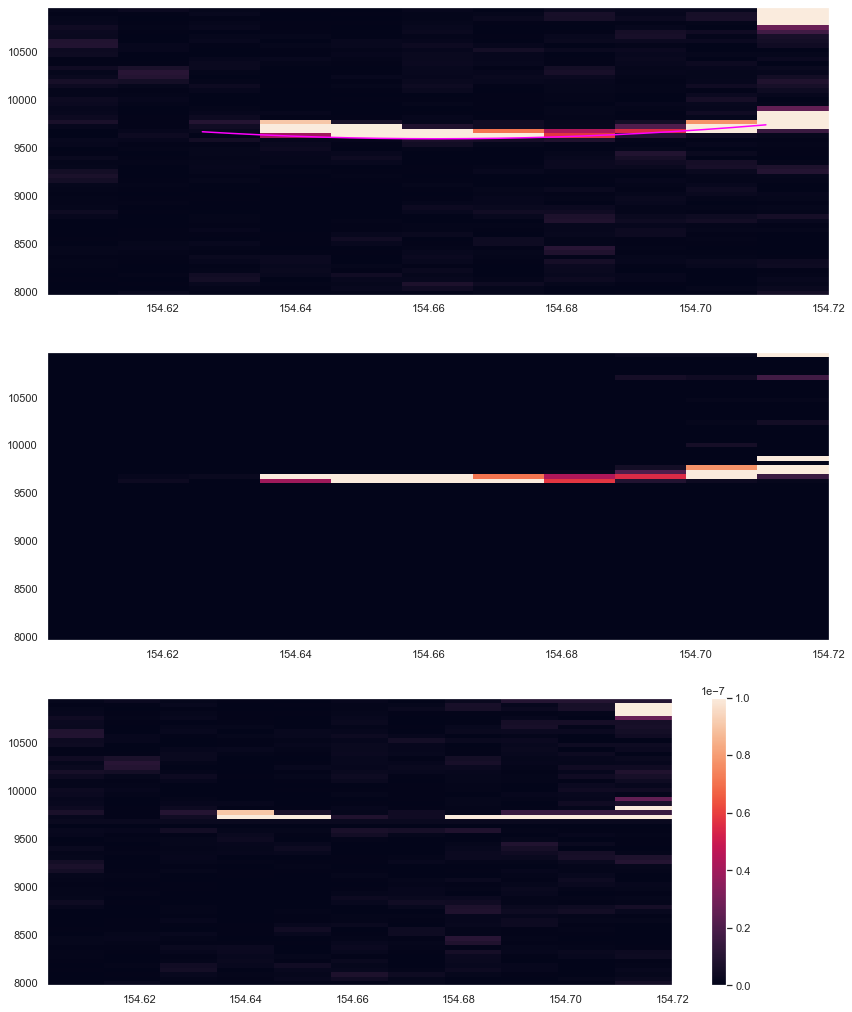

In [97]:
k = 504

f_arr, t_arr = freq_time_target_inds_array[k]
time_ind_min = np.min(t_arr)
time_ind_max = np.max(t_arr)

X_signal_windowed = X_signal[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)]
X_noise_windowed = X_noise[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)]

vmax = 1e-7

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,18))
bar = ax1.pcolormesh(times[time_ind_min:time_ind_max], freqs[freq_ind_min:freq_ind_max], Xdb[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)], vmin=0, vmax=vmax)
ax1.plot(time_freq[k][0][1], time_freq[k][0][0], color='magenta')
plt.colorbar(bar)

ax2.pcolormesh(times[time_ind_min:time_ind_max], freqs[freq_ind_min:freq_ind_max], X_signal[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)], vmin=0, vmax=vmax)
ax3.pcolormesh(times[time_ind_min:time_ind_max], freqs[freq_ind_min:freq_ind_max], X_noise[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)], vmin=0, vmax=vmax)

SNR:  1.4775630559563537


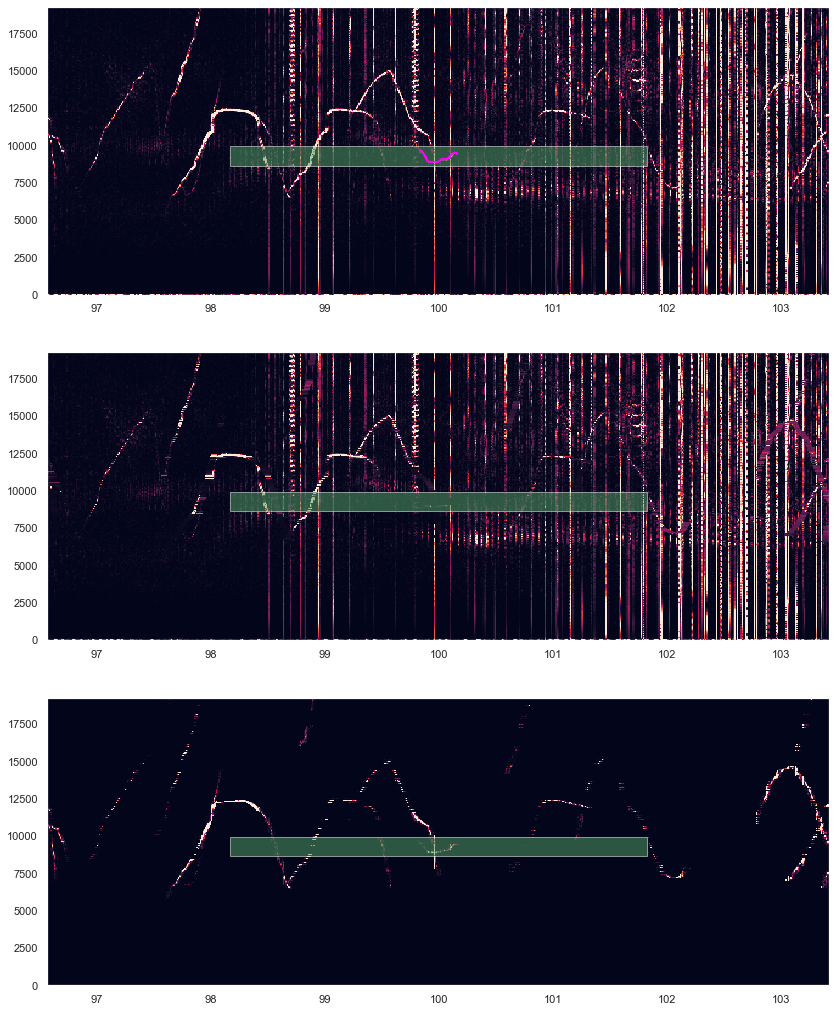

In [102]:
vmax = 1e-7
k = k_arr[2]

time_wind = 300
freq_wind = 200

####################

t_min = np.min(time_freq[k][0][1])
t_max = np.max(time_freq[k][0][1])
time_ind_min = max(np.argmax(times[times <= t_min]), 0)
time_ind_max = min(np.argmax(times[times < t_max]) + 1, times.size-1)

X_signal_windowed = X_signal[freq_ind_min:freq_ind_max, time_ind_min:time_ind_max]
X_noise_windowed = X_noise[freq_ind_min:freq_ind_max, time_ind_min:time_ind_max]

snr, P_signal, P_noise = signal_to_noise_ratio(X_signal_windowed, X_noise_windowed)

print("SNR: ", snr)

####################

vals, freq_ind_min_wind, freq_ind_max_wind, time_ind_min_wind, time_ind_max_wind = get_labels(freqs, 
                                                                                              times, 
                                                                                              time_freq[k][0][0], 
                                                                                              time_freq[k][0][1], 
                                                                                              5)
width = times[min(time_ind_max_wind + time_noise_points, len(times)-1)] - times[max(time_ind_min_wind - time_noise_points, 0)]
height = freqs[freq_ind_max_wind]-freqs[freq_ind_min_wind]
pc1 = PatchCollection([Rectangle((times[max(time_ind_min_wind - time_noise_points, 0)], freqs[freq_ind_min_wind]), width=width, height=height)],
                     facecolor='g', 
                     alpha=0.5,
                     edgecolor='white')
pc2 = PatchCollection([Rectangle((times[max(time_ind_min_wind - time_noise_points, 0)], freqs[freq_ind_min_wind]), width=width, height=height)],
                     facecolor='g', 
                     alpha=0.5,
                     edgecolor='white')
pc3 = PatchCollection([Rectangle((times[max(time_ind_min_wind - time_noise_points, 0)], freqs[freq_ind_min_wind]), width=width, height=height)],
                     facecolor='g', 
                     alpha=0.5,
                     edgecolor='white')


freq_ind_min_wind = max(freq_ind_min_wind-freq_wind, 0)
freq_ind_max_wind = min(freq_ind_max_wind + freq_wind, len(freqs)-1)
time_ind_min_wind = max(time_ind_min_wind - time_wind, 0)
time_ind_max_wind = min(time_ind_max_wind + time_wind, len(times)-1)

fig, (ax11, ax12, ax13) = plt.subplots(3, 1, figsize=(14,18))
bar = ax11.pcolormesh(times[time_ind_min_wind:time_ind_max_wind], freqs[freq_ind_min_wind:freq_ind_max_wind], Xdb[freq_ind_min_wind:freq_ind_max_wind, time_ind_min_wind:time_ind_max_wind], vmin=0, vmax=vmax)
ax11.plot(vals[:, 0], vals[:, 1], color='magenta')
ax11.add_collection(pc1)

ax12.pcolormesh(times[time_ind_min_wind:time_ind_max_wind], freqs[freq_ind_min_wind:freq_ind_max_wind], X_noise[freq_ind_min_wind:freq_ind_max_wind, time_ind_min_wind:time_ind_max_wind], vmin=0, vmax=vmax)
ax12.add_collection(pc2)

ax13.pcolormesh(times[time_ind_min_wind:time_ind_max_wind], freqs[freq_ind_min_wind:freq_ind_max_wind], X_signal[freq_ind_min_wind:freq_ind_max_wind, time_ind_min_wind:time_ind_max_wind], vmin=0, vmax=vmax)
ax13.add_collection(pc3)


# статистика встречаемости частот в контурах разметки

In [87]:
all_frequencies = []
all_frequencies_dups = []
all_range_conturs = []
for file in tqdm(glob.glob('dclmmpa2011-devel-bin/bottlenose/*'), position=0):
    time_freq = read_bin(file)
    
    for k in tqdm(range(len(time_freq)), position=0):
        
        for el in list(set(time_freq[k][0][0])):
            all_frequencies.append(el)
        
        for el in time_freq[k][0][0]:
            all_frequencies_dups.append(el)
            
        all_range_conturs.append(max(time_freq[k][0][0]) - min(time_freq[k][0][0]))

with open('/Users/alexeytyshko/Desktop/Aspa/all_frequencies.pkl', 'wb') as f:
    pkl.dump(all_frequencies, f)
    
with open('/Users/alexeytyshko/Desktop/Aspa/all_frequencies_dups.pkl', 'wb') as f:
    pkl.dump(all_frequencies_dups, f)
    
with open('/Users/alexeytyshko/Desktop/Aspa/all_range_conturs.pkl', 'wb') as f:
    pkl.dump(all_range_conturs, f)

100%|██████████| 340/340 [00:00<00:00, 6154.20it/s]
0it [00:00, ?it/s]/11 [00:00<00:01,  4.22it/s]
0it [00:00, ?it/s]
100%|██████████| 11/11 [00:01<00:00,  5.59it/s]


In [14]:
with open('/Users/alexeytyshko/Desktop/Aspa/all_frequencies.pkl', 'rb') as f:
    all_frequencies = pkl.load(f)
    
with open('/Users/alexeytyshko/Desktop/Aspa/all_frequencies_dups.pkl', 'rb') as f:
    all_frequencies_dups = pkl.load(f)
    
with open('/Users/alexeytyshko/Desktop/Aspa/all_range_conturs.pkl', 'rb') as f:
    all_range_conturs = pkl.load(f)

проверить с пересечениями

## плотность распределения встречаемости частот только для уникальных частот и с повторениями

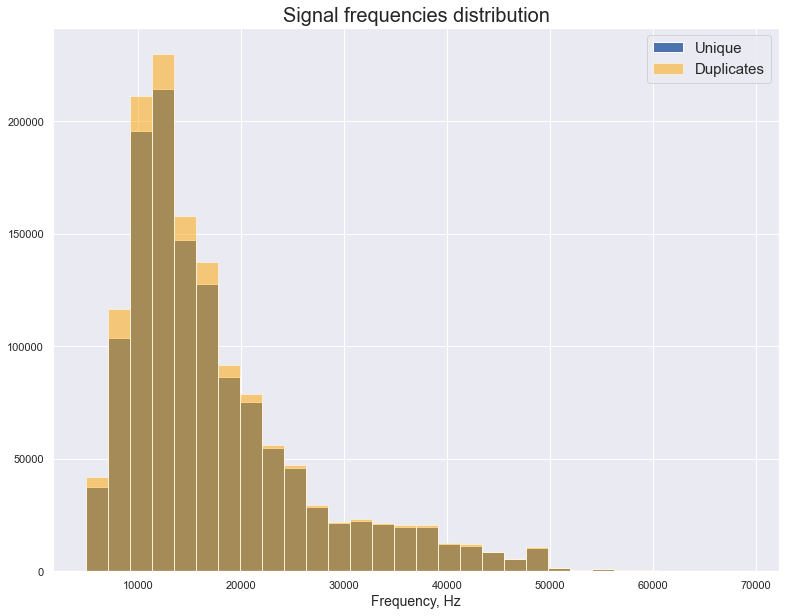

In [15]:
plt.figure(figsize=(13,10))
plt.xlabel('Frequency, Hz', fontsize=14)
plt.title('Signal frequencies distribution', fontsize=20)
plt.hist(all_frequencies, bins=30, color='b', label='Unique')

plt.hist(all_frequencies_dups, bins=30, color='orange', alpha=0.5, label='Duplicates')
plt.legend(prop={'size':15})

No handles with labels found to put in legend.
No handles with labels found to put in legend.


--- Unique ---
Mean:  17548.943892394076
Median:  14674.670566645998
1st quartile:  11231.475069260134
3d quartile:  21084.95991534491
5 percentile:  7770.449848305509


--- Duplicates ---
Mean:  17366.955395753263
Median:  14532.466134451633
1st quartile:  11145.21903648036
3d quartile:  20786.82269661565
5 percentile:  7736.685010228782


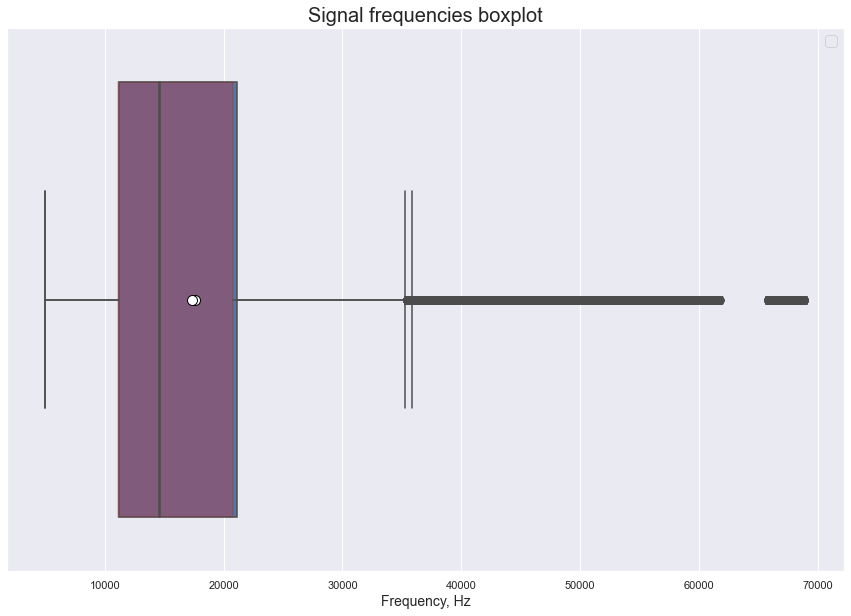

In [17]:
plt.figure(figsize=(15,10))
plt.title('Signal frequencies boxplot', fontsize=20)
plt.xlabel('Frequency, Hz', fontsize=14)
plt.legend(prop={'size':15})
ax = sns.boxplot(all_frequencies, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
# с дубликатами, цвет - красный
ax = sns.boxplot(all_frequencies_dups, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}, color='red', boxprops=dict(alpha=0.3))


print('--- Unique ---')
print('Mean: ', np.mean(all_frequencies))
print('Median: ', np.median(all_frequencies))
print('1st quartile: ', np.percentile(all_frequencies, 25))
print('3d quartile: ', np.percentile(all_frequencies, 75))
print('5 percentile: ', np.percentile(all_frequencies, 5))

print('\n\n--- Duplicates ---')
print('Mean: ', np.mean(all_frequencies_dups))
print('Median: ', np.median(all_frequencies_dups))
print('1st quartile: ', np.percentile(all_frequencies_dups, 25))
print('3d quartile: ', np.percentile(all_frequencies_dups, 75))
print('5 percentile: ', np.percentile(all_frequencies_dups, 5))

## распределение диапазона частот (max_freq - min_freq) для контуров

(array([318., 504., 411., 358., 287., 253., 227., 182., 153., 118.,  94.,
         65.,  52.,  39.,  35.,  17.,  27.,  18.,  11.,   8.,   5.,   5.,
          4.,   5.,   4.,   2.,   2.,   2.,   0.,   2.]),
 array([    0.        ,   961.14215381,  1922.28430762,  2883.42646142,
         3844.56861523,  4805.71076904,  5766.85292285,  6727.99507665,
         7689.13723046,  8650.27938427,  9611.42153808, 10572.56369189,
        11533.70584569, 12494.8479995 , 13455.99015331, 14417.13230712,
        15378.27446092, 16339.41661473, 17300.55876854, 18261.70092235,
        19222.84307615, 20183.98522996, 21145.12738377, 22106.26953758,
        23067.41169139, 24028.55384519, 24989.695999  , 25950.83815281,
        26911.98030662, 27873.12246042, 28834.26461423]),
 <BarContainer object of 30 artists>)

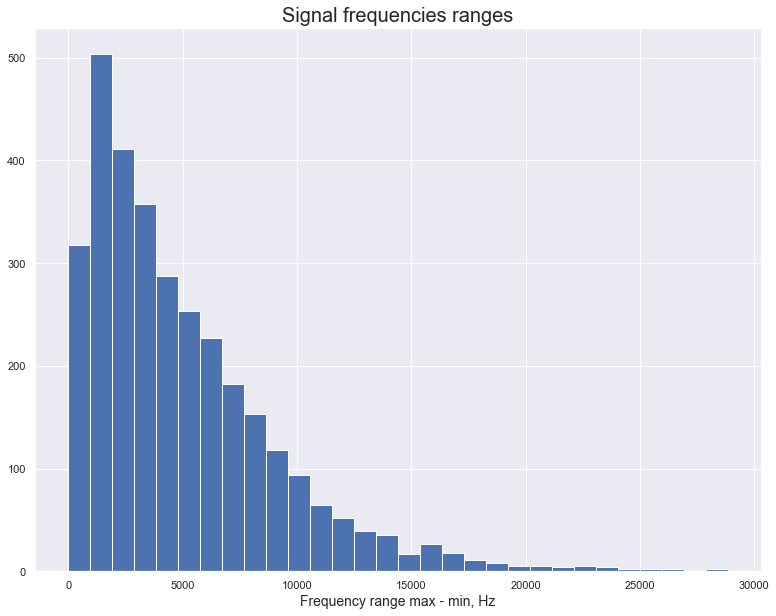

In [105]:
plt.figure(figsize=(13,10))
plt.xlabel('Frequency range max - min, Hz', fontsize=14)
plt.title('Signal frequencies ranges', fontsize=20)
plt.hist(all_range_conturs, bins=30, color='b')

# как зависит snr от частотного диапазона

## Первый способ

In [ ]:
import warnings
warnings.filterwarnings('ignore')

sr = 192000

# freq_min_max_array_1 = [[8000, x] for x in range(11000, 50000, 3000)]
freq_min_max_array_2 = [[11000, x] for x in range(14000, 50000, 3000)]
freq_min_max_array_3 = [[14000, x] for x in range(18000, 50000, 3000)]
freq_min_max_array_4 = [[17000, x] for x in range(20000, 50000, 3000)]
freq_min_max_array_5 = [[8000, x] for x in range(13000, 50000, 5000)]
freq_min_max_array_6 = [[13000, x] for x in range(18000, 50000, 5000)]
freq_min_max_array_7 = [[18000, x] for x in range(23000, 50000, 5000)]
freq_min_max_array_8 = [[23000, x] for x in range(28000, 50000, 5000)]
freq_min_max_arrays = [freq_min_max_array_2, freq_min_max_array_3, freq_min_max_array_4,
                       freq_min_max_array_5, freq_min_max_array_6, freq_min_max_array_7, freq_min_max_array_8]
# freq_min_max_arrays = [freq_min_max_array_1, freq_min_max_array_2, freq_min_max_array_3, freq_min_max_array_4,
#                        freq_min_max_array_5, freq_min_max_array_6, freq_min_max_array_7, freq_min_max_array_8]

n_fft = 4096

signal_points = 2
time_noise_points = 150

snr_1 = {}
P_signal_1 = {}
P_noise_1 = {}

snr_array = []
for freq_min_max_array in tqdm(freq_min_max_arrays, position=0):
    for freq_min, freq_max in freq_min_max_array:
        snr_array_local = []
        snr_array.append([freq_min, freq_max, snr_array_local])
        for file in glob.glob('dclmmpa2011-devel-bin/bottlenose/*'):
            
            time_freq = read_bin(file)
            
            path_1 = 'data/5th_DCL_data_bottlenose/{0}.wav'.format(file.split('/')[-1].split('.')[0])
            
            x = read_audio(path_1, path_2=None, sr=sr, w1=1, w2=0)
    
            freqs, times, X = stft(x, fs=sr, nperseg=n_fft, noverlap=n_fft/2)
            Xdb = X.real**2 + X.imag**2
            
            X_signal, X_noise, freq_time_target_inds_array, k_arr = signal_noise_derive_1(freqs, times, Xdb, time_freq, signal_points, time_noise_points, freq_min, freq_max)
            
            freq_ind_min = np.argmax(freqs[freqs <= freq_min])
            freq_ind_max = min(np.argmax(freqs[freqs < freq_max]) + 1, freqs.size - 1)
            
            for k in k_arr:
                
                f_arr, t_arr = freq_time_target_inds_array[k]
                
                X_signal_windowed = X_signal[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)]
                X_noise_windowed = X_noise[freq_ind_min:freq_ind_max, np.min(t_arr):np.max(t_arr)]
                
                snr, P_signal, P_noise = signal_to_noise_ratio(X_signal_windowed, X_noise_windowed)
                
                snr_array_local.append(snr)
    
####################

with open('snr_array_1_2.pkl', 'wb') as f:
    pkl.dump(snr_array, f)

with open('P_signal_1.pkl', 'wb') as f:
    pkl.dump(P_signal_1, f)
    
with open('P_noise_1.pkl', 'wb') as f:
    pkl.dump(P_noise_1, f)

100%|██████████| 340/340 [00:30<00:00, 11.01it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 340/340 [00:31<00:00, 10.90it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 340/340 [00:31<00:00, 10.86it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 340/340 [00:36<00:00,  9.29it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 340/340 [00:32<00:00, 10.35it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 13%|█▎        | 190/1444 [00:35<03:04,  6.80it/s]

### считываем массивы снр и счиатем статистики + кусок неактуального кода для мощностей

In [108]:
with open('snr_array_1_1.pkl', 'rb') as f:
    snr_array_1 = pkl.load(f)

with open('P_signal_1.pkl', 'rb') as f:
    P_signal_1 = pkl.load(f)
    
with open('P_noise_1.pkl', 'rb') as f:
    P_noise_1 = pkl.load(f)
    
####################
        
snr_array_means_1 = []
snr_array_stds_1 = []
snr_array_medians_1 = []
for freq_min, freq_max, arr in snr_array_1:
    snr_array_means_1.append([freq_min, freq_max, mean_confidence_interval(arr)])
    snr_array_stds_1.append([freq_min, freq_max, np.std(arr)])
    snr_array_medians_1.append([freq_min, freq_max, np.median(arr)])
####################
        
# signal_power_dist_1 = np.zeros(list(P_signal_1.items())[0][1].shape[0])
# noise_power_dist_1 = np.zeros(list(P_noise_1.items())[0][1].shape[0])

# for key, val in tqdm(P_signal_1.items(), position=0):
#     for i in range(val.shape[0]):
#         temp_val = val[i,:]
#         signal_power_dist_1[i] += (lambda x: x.mean() if list(x) else 0)(temp_val[temp_val!=0])
# signal_power_dist_1 = signal_power_dist_1/len(P_signal_1)
    
# for key, val in tqdm(P_noise_1.items(), position=0):
#     for i in range(val.shape[0]):
#         temp_val = val[i,:]
#         noise_power_dist_1[i] += temp_val[temp_val!=-1].mean()
# noise_power_dist_1 = noise_power_dist_1/len(P_noise_1)

### распределяем значения по соответствующим массивам

In [9]:
x_mean_8_3__1 = []
y_mean_8_3__1 = []
mean_conf_int_8_3__1 = []

x_mean_11_3__1 = []
y_mean_11_3__1 = []
mean_conf_int_11_3__1 = []

x_mean_14_3__1 = []
y_mean_14_3__1 = []
mean_conf_int_14_3__1 = []

x_mean_17_3__1 = []
y_mean_17_3__1 = []
mean_conf_int_17_3__1 = []

x_mean_8_5__1 = []
y_mean_8_5__1 = []
mean_conf_int_8_5__1 = []

x_mean_13_5__1 = []
y_mean_13_5__1 = []
mean_conf_int_13_5__1 = []

x_mean_18_5__1 = []
y_mean_18_5__1 = []
mean_conf_int_18_5__1 = []

x_mean_23_5__1 = []
y_mean_23_5__1 = []
mean_conf_int_23_5__1 = []

k = 0
for fmin, fmax, mci in snr_array_means_1:
    
    if k <= 12:
        x_mean_8_3__1.append(fmax)
        y_mean_8_3__1.append(mci[0])
        mean_conf_int_8_3__1.append(mci[3])
        
    
    elif k >= 13 and k <= 24:
        x_mean_11_3__1.append(fmax)
        y_mean_11_3__1.append(mci[0])
        mean_conf_int_11_3__1.append(mci[3])
    
    elif k >= 25 and k <= 35:
        x_mean_14_3__1.append(fmax)
        y_mean_14_3__1.append(mci[0])
        mean_conf_int_14_3__1.append(mci[3])
        
    elif k >= 36 and k <= 45:
        x_mean_17_3__1.append(fmax)
        y_mean_17_3__1.append(mci[0])
        mean_conf_int_17_3__1.append(mci[3])
    
    elif k >= 46 and k <= 53:
        x_mean_8_5__1.append(fmax)
        y_mean_8_5__1.append(mci[0])
        mean_conf_int_8_5__1.append(mci[3])
        
    elif k >= 54 and k <= 60:
        x_mean_13_5__1.append(fmax)
        y_mean_13_5__1.append(mci[0])
        mean_conf_int_13_5__1.append(mci[3])
        
    elif k >= 61 and k <= 66:
        x_mean_18_5__1.append(fmax)
        y_mean_18_5__1.append(mci[0])
        mean_conf_int_18_5__1.append(mci[3])
        
    elif k >= 67:
        x_mean_23_5__1.append(fmax)
        y_mean_23_5__1.append(mci[0])
        mean_conf_int_23_5__1.append(mci[3])

    k += 1

In [10]:
x_std_8_3__1 = []
y_std_8_3__1 = []

x_std_11_3__1 = []
y_std_11_3__1 = []

x_std_14_3__1 = []
y_std_14_3__1 = []

x_std_17_3__1 = []
y_std_17_3__1 = []

x_std_8_5__1 = []
y_std_8_5__1 = []

x_std_13_5__1 = []
y_std_13_5__1 = []

x_std_18_5__1 = []
y_std_18_5__1 = []

x_std_23_5__1 = []
y_std_23_5__1 = []

k = 0
for fmin, fmax, snr in snr_array_stds_1:
    
    if k <= 12:
        x_std_8_3__1.append(fmax)
        y_std_8_3__1.append(snr)
    
    elif k >= 13 and k <= 24:
        x_std_11_3__1.append(fmax)
        y_std_11_3__1.append(snr)
    
    elif k >= 25 and k <= 35:
        x_std_14_3__1.append(fmax)
        y_std_14_3__1.append(snr)
        
    elif k >= 36 and k <= 45:
        x_std_17_3__1.append(fmax)
        y_std_17_3__1.append(snr)
    
    elif k >= 46 and k <= 53:
        x_std_8_5__1.append(fmax)
        y_std_8_5__1.append(snr)
        
    elif k >= 54 and k <= 60:
        x_std_13_5__1.append(fmax)
        y_std_13_5__1.append(snr)
        
    elif k >= 61 and k <= 66:
        x_std_18_5__1.append(fmax)
        y_std_18_5__1.append(snr)
        
    elif k >= 67:
        x_std_23_5__1.append(fmax)
        y_std_23_5__1.append(snr)
        
    k += 1

In [11]:
x_median_8_3__1 = []
y_median_8_3__1 = []

x_median_11_3__1 = []
y_median_11_3__1 = []

x_median_14_3__1 = []
y_median_14_3__1 = []

x_median_17_3__1 = []
y_median_17_3__1 = []

x_median_8_5__1 = []
y_median_8_5__1 = []

x_median_13_5__1 = []
y_median_13_5__1 = []

x_median_18_5__1 = []
y_median_18_5__1 = []

x_median_23_5__1 = []
y_median_23_5__1 = []

k = 0
for fmin, fmax, snr in snr_array_medians_1:
    
    if k <= 12:
        x_median_8_3__1.append(fmax)
        y_median_8_3__1.append(snr)
    
    elif k >= 13 and k <= 24:
        x_median_11_3__1.append(fmax)
        y_median_11_3__1.append(snr)
    
    elif k >= 25 and k <= 35:
        x_median_14_3__1.append(fmax)
        y_median_14_3__1.append(snr)
        
    elif k >= 36 and k <= 45:
        x_median_17_3__1.append(fmax)
        y_median_17_3__1.append(snr)
    
    elif k >= 46 and k <= 53:
        x_median_8_5__1.append(fmax)
        y_median_8_5__1.append(snr)
        
    elif k >= 54 and k <= 60:
        x_median_13_5__1.append(fmax)
        y_median_13_5__1.append(snr)
        
    elif k >= 61 and k <= 66:
        x_median_18_5__1.append(fmax)
        y_median_18_5__1.append(snr)
        
    elif k >= 67:
        x_median_23_5__1.append(fmax)
        y_median_23_5__1.append(snr)
        
    k += 1

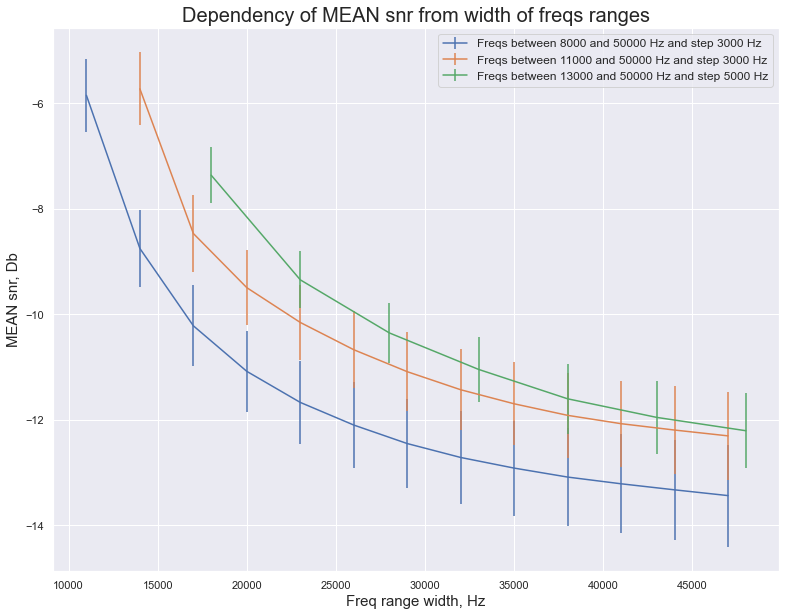

In [50]:
plt.figure(figsize=(13,10))

plt.title('Dependency of MEAN snr from width of freqs ranges', fontsize=20)

plt.errorbar(x_mean_8_3__1, y_mean_8_3__1, yerr=mean_conf_int_8_3__1, label='Freqs between 8000 and 50000 Hz and step 3000 Hz')
plt.errorbar(x_mean_11_3__1, y_mean_11_3__1, yerr=mean_conf_int_11_3__1, label='Freqs between 11000 and 50000 Hz and step 3000 Hz')
# # plt.errorbar(x_mean_14_3__1, y_mean_14_3__1, yerr=mean_conf_int_14_3__1, label='Freqs between 14000 and 50000 Hz and step 3000 Hz')
# plt.errorbar(x_mean_17_3__1, y_mean_17_3__1, yerr=mean_conf_int_17_3__1, label='Freqs between 17000 and 50000 Hz and step 3000 Hz')
# plt.errorbar(x_mean_8_5__1, y_mean_8_5__1, yerr=mean_conf_int_8_5__1, label='Freqs between 8000 and 50000 Hz and step 4000/3000 Hz')
plt.errorbar(x_mean_13_5__1, y_mean_13_5__1, yerr=mean_conf_int_13_5__1, label='Freqs between 13000 and 50000 Hz and step 5000 Hz')
# plt.errorbar(x_mean_18_5__1, y_mean_18_5__1, yerr=mean_conf_int_18_5__1, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')
# plt.errorbar(x_mean_23_5__1, y_mean_23_5__1, yerr=mean_conf_int_23_5__1, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('MEAN snr, Db', fontsize=15)

plt.legend(prop={'size':12})


Оформить в виде текста рез-ты. Вывод: для снр важен верхняя граница диапазона частот. 
Поставленный вопрос (некоторая свобода в определении снр частотный диапазон) - Влияет ли на снр опр-я контуров частотный диапазон. Есть интуитивное понимание что опр-е снр будет влиять на надежность опр-я контуров.

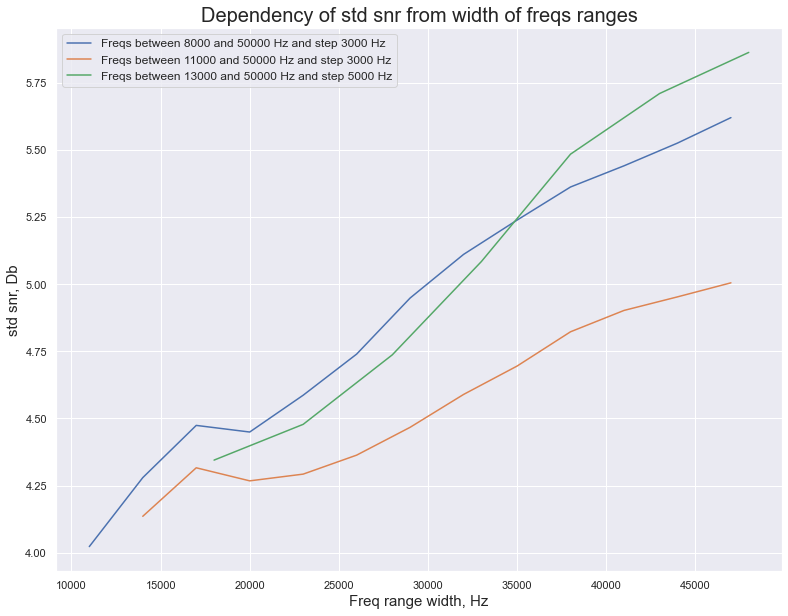

In [49]:
plt.figure(figsize=(13,10))

plt.title('Dependency of std snr from width of freqs ranges', fontsize=20)

plt.plot(x_std_8_3__1, y_std_8_3__1, label='Freqs between 8000 and 50000 Hz and step 3000 Hz')
plt.plot(x_std_11_3__1, y_std_11_3__1, label='Freqs between 11000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_std_14_3__1, y_std_14_3__1, label='Freqs between 14000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_std_17_3__1, y_std_17_3__1, label='Freqs between 17000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_std_8_5__1, y_std_8_5__1, label='Freqs between 8000 and 50000 Hz and step 4000/3000 Hz')
plt.plot(x_std_13_5__1, y_std_13_5__1, label='Freqs between 13000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_std_18_5__1, y_std_18_5__1, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_std_23_5__1, y_std_23_5__1, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('std snr, Db', fontsize=15)

plt.legend(prop={'size':12})


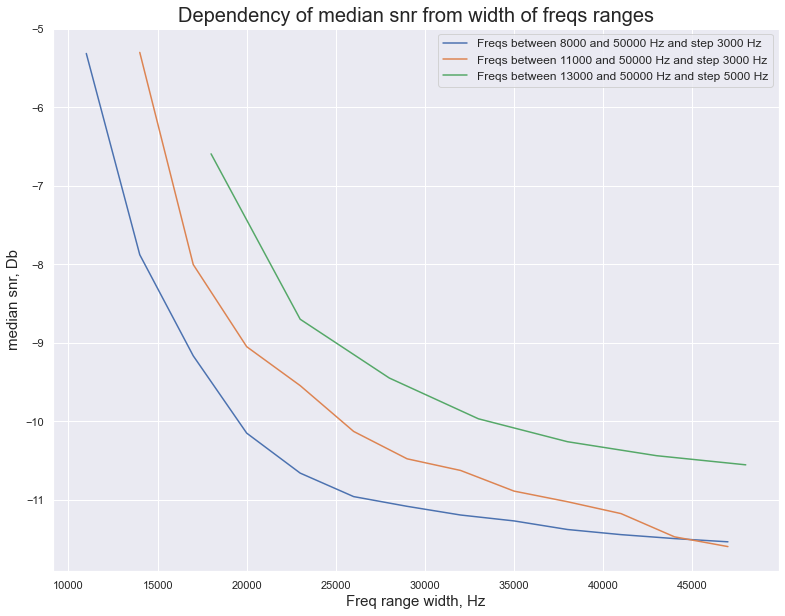

In [48]:
plt.figure(figsize=(13,10))

plt.title('Dependency of median snr from width of freqs ranges', fontsize=20)

plt.plot(x_median_8_3__1, y_median_8_3__1, label='Freqs between 8000 and 50000 Hz and step 3000 Hz')
plt.plot(x_median_11_3__1, y_median_11_3__1, label='Freqs between 11000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_median_14_3__1, y_median_14_3__1, label='Freqs between 14000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_median_17_3__1, y_median_17_3__1, label='Freqs between 17000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_median_8_5__1, y_median_8_5__1, label='Freqs between 8000 and 50000 Hz and step 4000/3000 Hz')
plt.plot(x_median_13_5__1, y_median_13_5__1, label='Freqs between 13000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_median_18_5__1, y_median_18_5__1, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_median_23_5__1, y_median_23_5__1, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('median snr, Db', fontsize=15)

plt.legend(prop={'size':12})


найти ошибку во втором способе и пересчитать первый для контуров полностью попадающих в пересечение диапазонов, попробовать разные диапазоны
зафиксировать нижнюю границу частоты и подвигать верхнюю и посмотреть статистики снр

для второго способа ограничивать частоты ровно по контуру

вероятность обнаружения тональных акустических сигналов в зависимости от соотношения сигнал/шум

## Второй способ


In [18]:
import warnings
warnings.filterwarnings('ignore')

sr = 192000

freq_min_max_array_1 = [[8000, x] for x in range(11000, 50000, 3000)]
freq_min_max_array_2 = [[11000, x] for x in range(14000, 50000, 3000)]
freq_min_max_array_3 = [[14000, x] for x in range(18000, 50000, 3000)]
freq_min_max_array_4 = [[17000, x] for x in range(20000, 50000, 3000)]
freq_min_max_array_5 = [[8000, x] for x in range(13000, 50000, 5000)]
freq_min_max_array_6 = [[13000, x] for x in range(18000, 50000, 5000)]
freq_min_max_array_7 = [[18000, x] for x in range(23000, 50000, 5000)]
freq_min_max_array_8 = [[23000, x] for x in range(28000, 50000, 5000)]
freq_min_max_arrays = [freq_min_max_array_1, freq_min_max_array_2, freq_min_max_array_3, freq_min_max_array_4,
                       freq_min_max_array_5, freq_min_max_array_6, freq_min_max_array_7, freq_min_max_array_8]

n_fft = 4096

signal_points = 2
time_noise_points = 300

snr_2 = {}
P_signal_2 = {}
P_noise_2 = {}

snr_array = []
for freq_min_max_array in tqdm(freq_min_max_arrays, position=0):
    for freq_min, freq_max in freq_min_max_array:
        snr_array_local = []
        snr_array.append([freq_min, freq_max, snr_array_local])
        for file in glob.glob('dclmmpa2011-devel-bin/bottlenose/*'):
            
            time_freq = read_bin(file)
            
            path_1 = 'data/5th_DCL_data_bottlenose/{0}.wav'.format(file.split('/')[-1].split('.')[0])
            
            x = read_audio(path_1, path_2, sr=sr, w1=1, w2=0)
    
            freqs, times, X = stft(x, fs=sr, nperseg=n_fft, noverlap=n_fft/2)
            Xdb = X.real**2 + X.imag**2
    
            X_signal = np.zeros(Xdb.shape)
            X_noise = np.copy(Xdb)
            
            freq_ind_min = max(np.argmax(freqs[freqs <= freq_min]), 0)
            freq_ind_max = min(np.argmax(freqs[freqs < freq_max]) + 1, freqs.size-1)
            
            #### Первый проход для вырезания сигнала из спектрограммы ####
            
            for k in range(len(time_freq)):
            
                t_min = np.min(time_freq[k][0][1])
                t_max = np.max(time_freq[k][0][1])
                time_ind_min = max(np.argmax(times[times <= t_min]), 0)
                time_ind_max = min(np.argmax(times[times < t_max]) + 1, times.size-1)
        
                X_signal[:, time_ind_min:time_ind_max] = Xdb[:, time_ind_min:time_ind_max]
                X_noise[:, time_ind_min:time_ind_max] = -1
                
            #### Второй проход для заполнения средними значениями шума куски, из которых вырезан сигнал ####
    
            for k in range(len(time_freq)):
            
                t_min = np.min(time_freq[k][0][1])
                t_max = np.max(time_freq[k][0][1])
                time_ind_min = max(np.argmax(times[times <= t_min]), 0)
                time_ind_max = min(np.argmax(times[times < t_max]) + 1, times.size-1)

                for i in range(freqs.size):
                    noise_tmp = X_noise[i, max(time_ind_min-time_noise_points, 0):min(time_ind_max+time_noise_points, times.size-1)]
                    X_noise[i, time_ind_min:time_ind_max] = noise_tmp[noise_tmp!=-1].mean()
                
                if min(time_freq[k][0][0]) >= freq_min_max_array[0][0] and max(time_freq[k][0][0]) <= freq_min_max_array[0][1]:

                    X_signal_windowed = X_signal[freq_ind_min:freq_ind_max, time_ind_min:time_ind_max]
                    X_noise_windowed = X_noise[freq_ind_min:freq_ind_max, time_ind_min:time_ind_max]

                    snr, P_signal, P_noise = signal_to_noise_ratio(X_signal_windowed, X_noise_windowed)

                    snr_array_local.append(snr)

    P_signal_2[file] = X_signal
    P_noise_2[file] = X_noise
    
####################

with open('snr_array_2.pkl', 'wb') as f:
    pkl.dump(snr_array, f)

with open('P_signal_2.pkl', 'wb') as f:
    pkl.dump(P_signal_2, f)
    
with open('P_noise_2.pkl', 'wb') as f:
    pkl.dump(P_noise_2, f)

100%|██████████| 8/8 [3:50:23<00:00, 1727.93s/it]  


### считываем массивы снр и счиатем статистики + кусок неактуального кода для мощностей

In [10]:
with open('snr_array_2.pkl', 'rb') as f:
    snr_array_2 = pkl.load(f)

with open('P_signal_2.pkl', 'rb') as f:
    P_signal_2 = pkl.load(f)
    
with open('P_noise_2.pkl', 'rb') as f:
    P_noise_2 = pkl.load(f)
    
####################
        
snr_array_means_2 = []
snr_array_stds_2 = []
snr_array_medians_2 = []
for freq_min, freq_max, arr in snr_array_2:
    snr_array_means_2.append([freq_min, freq_max, mean_confidence_interval(arr)])
    snr_array_stds_2.append([freq_min, freq_max, np.std(arr)])
    snr_array_medians_2.append([freq_min, freq_max, np.median(arr)])
####################
        
# signal_power_dist_2 = np.zeros(list(P_signal_2.items())[0][1].shape[0])
# noise_power_dist_2 = np.zeros(list(P_noise_2.items())[0][1].shape[0])

# for key, val in tqdm(P_signal_2.items(), position=0):
#     for i in range(val.shape[0]):
#         temp_val = val[i,:]
#         signal_power_dist_2[i] += (lambda x: x.mean() if list(x) else 0)(temp_val[temp_val!=0])
# signal_power_dist_2 = signal_power_dist_2/len(P_signal_2)
    
# for key, val in tqdm(P_noise_2.items(), position=0):
#     for i in range(val.shape[0]):
#         temp_val = val[i,:]
#         noise_power_dist_2[i] += temp_val[temp_val!=-1].mean()
# noise_power_dist_2 = noise_power_dist_2/len(P_noise_2)

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


### распределяем значения по соответствующим массивам

In [11]:
x_mean_8_3__2 = []
y_mean_8_3__2 = []
mean_conf_int_8_3__2 = []

x_mean_11_3__2 = []
y_mean_11_3__2 = []
mean_conf_int_11_3__2 = []

x_mean_14_3__2 = []
y_mean_14_3__2 = []
mean_conf_int_14_3__2 = []

x_mean_17_3__2 = []
y_mean_17_3__2 = []
mean_conf_int_17_3__2 = []

x_mean_8_5__2 = []
y_mean_8_5__2 = []
mean_conf_int_8_5__2 = []

x_mean_13_5__2 = []
y_mean_13_5__2 = []
mean_conf_int_13_5__2 = []

x_mean_18_5__2 = []
y_mean_18_5__2 = []
mean_conf_int_18_5__2 = []

x_mean_23_5__2 = []
y_mean_23_5__2 = []
mean_conf_int_23_5__2 = []

k = 0
for fmin, fmax, mci in snr_array_means_2:
    
    if k <= 12:
        x_mean_8_3__2.append(fmax)
        y_mean_8_3__2.append(mci[0])
        mean_conf_int_8_3__2.append(mci[3])
        
    
    elif k >= 13 and k <= 24:
        x_mean_11_3__2.append(fmax)
        y_mean_11_3__2.append(mci[0])
        mean_conf_int_11_3__2.append(mci[3])
    
    elif k >= 25 and k <= 35:
        x_mean_14_3__2.append(fmax)
        y_mean_14_3__2.append(mci[0])
        mean_conf_int_14_3__2.append(mci[3])
        
    elif k >= 36 and k <= 45:
        x_mean_17_3__2.append(fmax)
        y_mean_17_3__2.append(mci[0])
        mean_conf_int_17_3__2.append(mci[3])
    
    elif k >= 46 and k <= 53:
        x_mean_8_5__2.append(fmax)
        y_mean_8_5__2.append(mci[0])
        mean_conf_int_8_5__2.append(mci[3])
        
    elif k >= 54 and k <= 60:
        x_mean_13_5__2.append(fmax)
        y_mean_13_5__2.append(mci[0])
        mean_conf_int_13_5__2.append(mci[3])
        
    elif k >= 61 and k <= 66:
        x_mean_18_5__2.append(fmax)
        y_mean_18_5__2.append(mci[0])
        mean_conf_int_18_5__2.append(mci[3])
        
    elif k >= 67:
        x_mean_23_5__2.append(fmax)
        y_mean_23_5__2.append(mci[0])
        mean_conf_int_23_5__2.append(mci[3])

    k += 1

In [12]:
x_std_8_3__2 = []
y_std_8_3__2 = []

x_std_11_3__2 = []
y_std_11_3__2 = []

x_std_14_3__2 = []
y_std_14_3__2 = []

x_std_17_3__2 = []
y_std_17_3__2 = []

x_std_8_5__2 = []
y_std_8_5__2 = []

x_std_13_5__2 = []
y_std_13_5__2 = []

x_std_18_5__2 = []
y_std_18_5__2 = []

x_std_23_5__2 = []
y_std_23_5__2 = []

k = 0
for fmin, fmax, snr in snr_array_stds_2:
    
    if k <= 12:
        x_std_8_3__2.append(fmax)
        y_std_8_3__2.append(snr)
    
    elif k >= 13 and k <= 24:
        x_std_11_3__2.append(fmax)
        y_std_11_3__2.append(snr)
    
    elif k >= 25 and k <= 35:
        x_std_14_3__2.append(fmax)
        y_std_14_3__2.append(snr)
        
    elif k >= 36 and k <= 45:
        x_std_17_3__2.append(fmax)
        y_std_17_3__2.append(snr)
    
    elif k >= 46 and k <= 53:
        x_std_8_5__2.append(fmax)
        y_std_8_5__2.append(snr)
        
    elif k >= 54 and k <= 60:
        x_std_13_5__2.append(fmax)
        y_std_13_5__2.append(snr)
        
    elif k >= 61 and k <= 66:
        x_std_18_5__2.append(fmax)
        y_std_18_5__2.append(snr)
        
    elif k >= 67:
        x_std_23_5__2.append(fmax)
        y_std_23_5__2.append(snr)
        
    k += 1

In [13]:
x_median_8_3__2 = []
y_median_8_3__2 = []

x_median_11_3__2 = []
y_median_11_3__2 = []

x_median_14_3__2 = []
y_median_14_3__2 = []

x_median_17_3__2 = []
y_median_17_3__2 = []

x_median_8_5__2 = []
y_median_8_5__2 = []

x_median_13_5__2 = []
y_median_13_5__2 = []

x_median_18_5__2 = []
y_median_18_5__2 = []

x_median_23_5__2 = []
y_median_23_5__2 = []

k = 0
for fmin, fmax, snr in snr_array_medians_2:
    
    if k <= 12:
        x_median_8_3__2.append(fmax)
        y_median_8_3__2.append(snr)
    
    elif k >= 13 and k <= 24:
        x_median_11_3__2.append(fmax)
        y_median_11_3__2.append(snr)
    
    elif k >= 25 and k <= 35:
        x_median_14_3__2.append(fmax)
        y_median_14_3__2.append(snr)
        
    elif k >= 36 and k <= 45:
        x_median_17_3__2.append(fmax)
        y_median_17_3__2.append(snr)
    
    elif k >= 46 and k <= 53:
        x_median_8_5__2.append(fmax)
        y_median_8_5__2.append(snr)
        
    elif k >= 54 and k <= 60:
        x_median_13_5__2.append(fmax)
        y_median_13_5__2.append(snr)
        
    elif k >= 61 and k <= 66:
        x_median_18_5__2.append(fmax)
        y_median_18_5__2.append(snr)
        
    elif k >= 67:
        x_median_23_5__2.append(fmax)
        y_median_23_5__2.append(snr)
        
    k += 1

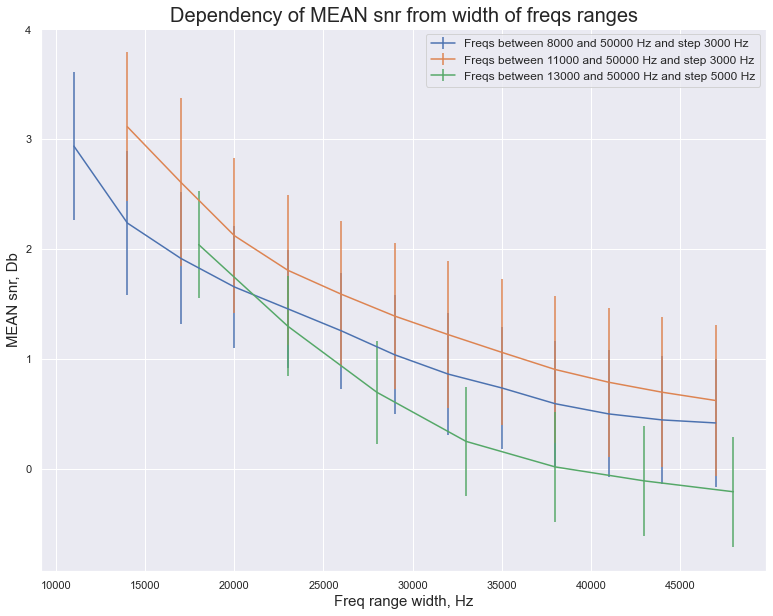

In [45]:
plt.figure(figsize=(13,10))

plt.title('Dependency of MEAN snr from width of freqs ranges', fontsize=20)

plt.errorbar(x_mean_8_3__2, y_mean_8_3__2, yerr=mean_conf_int_8_3__2, label='Freqs between 8000 and 50000 Hz and step 3000 Hz')
plt.errorbar(x_mean_11_3__2, y_mean_11_3__2, yerr=mean_conf_int_11_3__2, label='Freqs between 11000 and 50000 Hz and step 3000 Hz')
# # plt.errorbar(x_mean_14_3__2, y_mean_14_3__2, yerr=mean_conf_int_14_3__2, label='Freqs between 14000 and 50000 Hz and step 3000 Hz')
# plt.errorbar(x_mean_17_3__2, y_mean_17_3__2, yerr=mean_conf_int_17_3__2, label='Freqs between 17000 and 50000 Hz and step 3000 Hz')
# plt.errorbar(x_mean_8_5__2, y_mean_8_5__2, yerr=mean_conf_int_8_5__2, label='Freqs between 8000 and 50000 Hz and step 4000/3000 Hz')
plt.errorbar(x_mean_13_5__2, y_mean_13_5__2, yerr=mean_conf_int_13_5__2, label='Freqs between 13000 and 50000 Hz and step 5000 Hz')
# plt.errorbar(x_mean_18_5__2, y_mean_18_5__2, yerr=mean_conf_int_18_5__2, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')
# plt.errorbar(x_mean_23_5__2, y_mean_23_5__2, yerr=mean_conf_int_23_5__2, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('MEAN snr, Db', fontsize=15)

plt.legend(prop={'size':12})



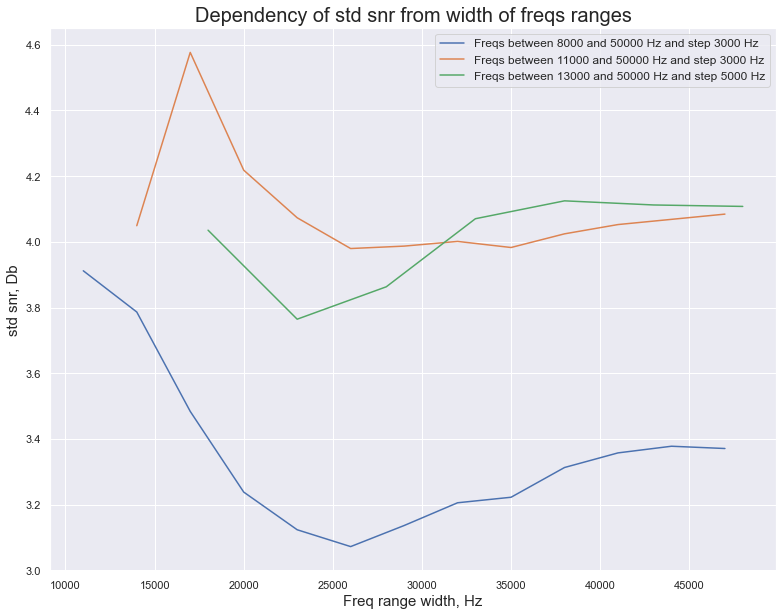

In [46]:
plt.figure(figsize=(13,10))

plt.title('Dependency of std snr from width of freqs ranges', fontsize=20)

plt.plot(x_std_8_3__2, y_std_8_3__2, label='Freqs between 8000 and 50000 Hz and step 3000 Hz')
plt.plot(x_std_11_3__2, y_std_11_3__2, label='Freqs between 11000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_std_14_3__2, y_std_14_3__2, label='Freqs between 14000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_std_17_3__2, y_std_17_3__2, label='Freqs between 17000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_std_8_5__2, y_std_8_5__2, label='Freqs between 8000 and 50000 Hz and step 4000/3000 Hz')
plt.plot(x_std_13_5__2, y_std_13_5__2, label='Freqs between 13000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_std_18_5__2, y_std_18_5__2, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_std_23_5__2, y_std_23_5__2, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('std snr, Db', fontsize=15)

plt.legend(prop={'size':12})



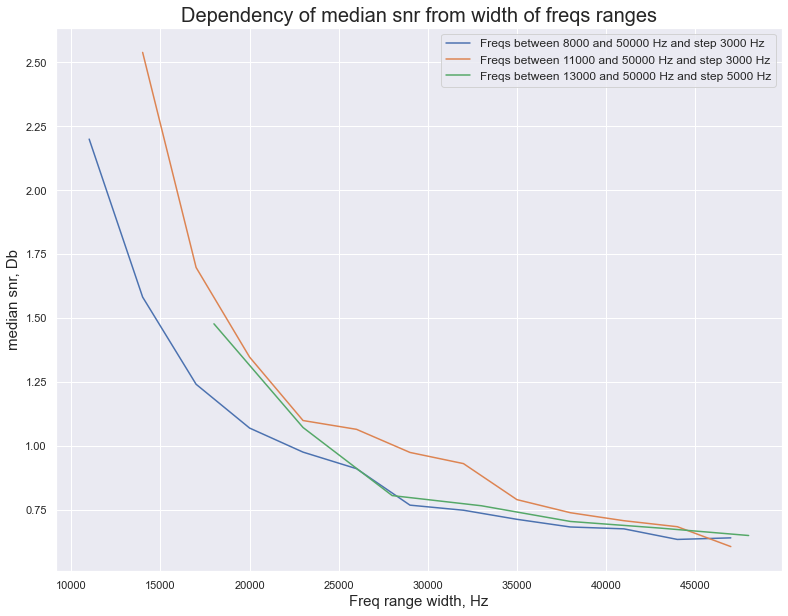

In [47]:
plt.figure(figsize=(13,10))

plt.title('Dependency of median snr from width of freqs ranges', fontsize=20)

plt.plot(x_median_8_3__2, y_median_8_3__2, label='Freqs between 8000 and 50000 Hz and step 3000 Hz')
plt.plot(x_median_11_3__2, y_median_11_3__2, label='Freqs between 11000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_median_14_3__2, y_median_14_3__2, label='Freqs between 14000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_median_17_3__2, y_median_17_3__2, label='Freqs between 17000 and 50000 Hz and step 3000 Hz')
# plt.plot(x_median_8_5__2, y_median_8_5__2, label='Freqs between 8000 and 50000 Hz and step 4000/3000 Hz')
plt.plot(x_median_13_5__2, y_median_13_5__2, label='Freqs between 13000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_median_18_5__2, y_median_18_5__2, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')
# plt.plot(x_median_23_5__2, y_median_23_5__2, label='Freqs between 18000 and 50000 Hz and step 5000 Hz')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('median snr, Db', fontsize=15)

plt.legend(prop={'size':12})



распределениие разности snr для двух способов и внутри одного способа для двух диапазонов

придумать как предсказать snr с помощью алгоритма на чистой записи без разметки

## Сравнение значений снр, посчитанных двумя способами

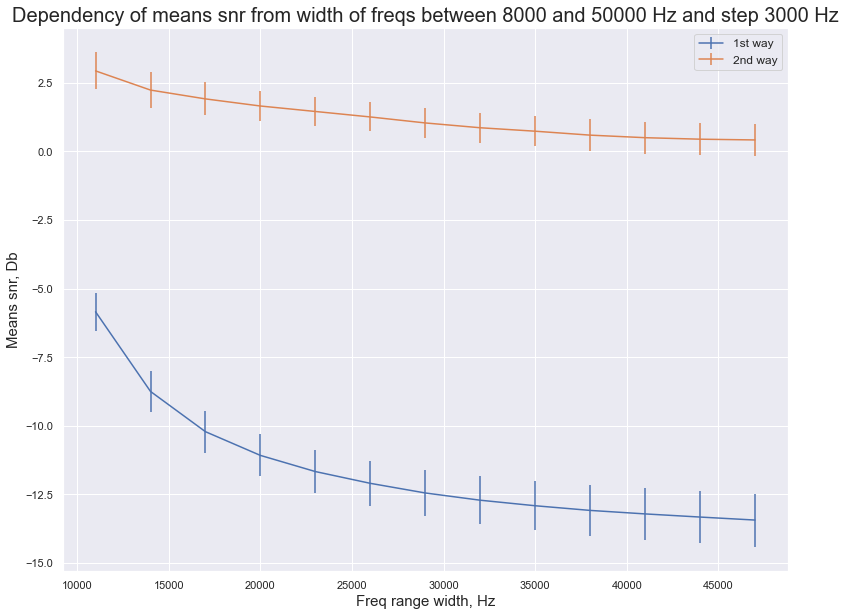

In [64]:
plt.figure(figsize=(13,10))

plt.title('Dependency of means snr from width of freqs between 8000 and 50000 Hz and step 3000 Hz', fontsize=20)

plt.errorbar(x_mean_8_3__1, y_mean_8_3__1, yerr=mean_conf_int_8_3__1, label='1st way')
plt.errorbar(x_mean_8_3__2, y_mean_8_3__2, yerr=mean_conf_int_8_3__2, label='2nd way')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('Means snr, Db', fontsize=15)

plt.legend(prop={'size':12})

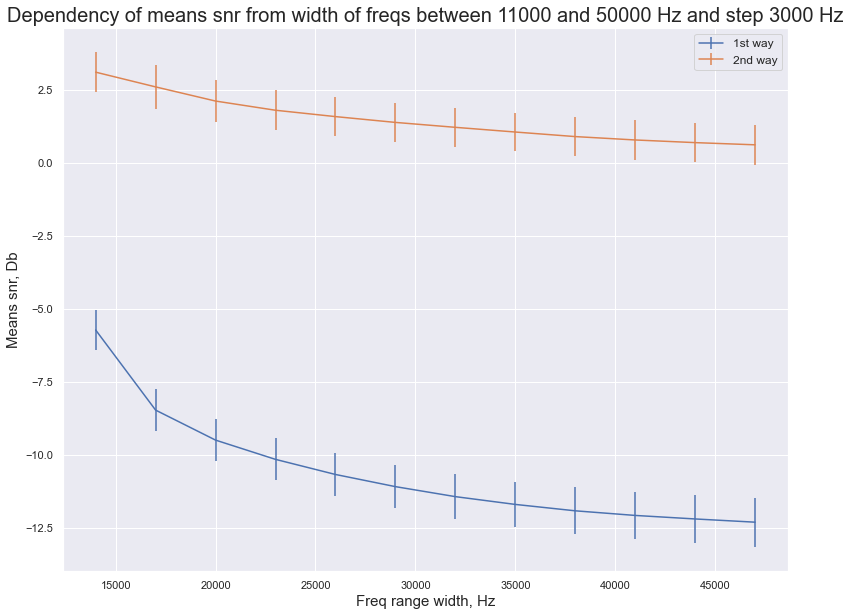

In [65]:
plt.figure(figsize=(13,10))

plt.title('Dependency of means snr from width of freqs between 11000 and 50000 Hz and step 3000 Hz', fontsize=20)

plt.errorbar(x_mean_11_3__1, y_mean_11_3__1, yerr=mean_conf_int_11_3__1, label='1st way')
plt.errorbar(x_mean_11_3__2, y_mean_11_3__2, yerr=mean_conf_int_11_3__2, label='2nd way')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('Means snr, Db', fontsize=15)

plt.legend(prop={'size':12})

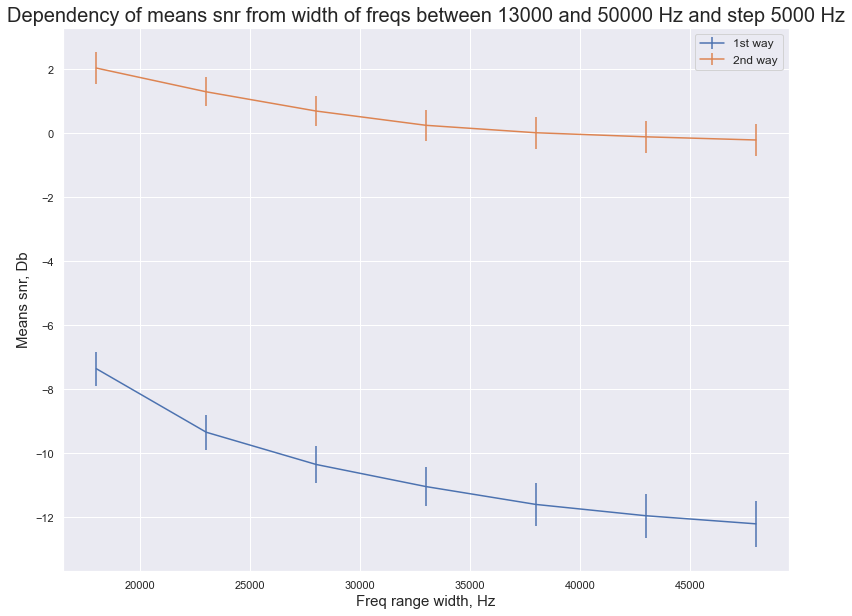

In [66]:
plt.figure(figsize=(13,10))

plt.title('Dependency of means snr from width of freqs between 13000 and 50000 Hz and step 5000 Hz', fontsize=20)

plt.errorbar(x_mean_13_5__1, y_mean_13_5__1, yerr=mean_conf_int_13_5__1, label='1st way')
plt.errorbar(x_mean_13_5__2, y_mean_13_5__2, yerr=mean_conf_int_13_5__2, label='2nd way')

plt.xlabel('Freq range width, Hz', fontsize=15)
plt.ylabel('Means snr, Db', fontsize=15)

plt.legend(prop={'size':12})

In [51]:
for i in range(len(snr_array_1)):
    for k in [k for k in range(len(snr_array_1)) if k > i]:
        if len(snr_array_1[i][2]) == len(snr_array_1[k][2]):
            assert wilcoxon(snr_array_1[i][2], snr_array_1[k][2])[1] <= 0.01

In [52]:
for i in range(len(snr_array_2)):
    for k in [k for k in range(len(snr_array_1)) if k > i]:
        if len(snr_array_2[i][2]) == len(snr_array_2[k][2]):
            assert wilcoxon(snr_array_2[i][2], snr_array_2[k][2])[1] <= 0.01

### распределение снр для одного из выбранных диапазонов для второго способа

(array([ 1., 11., 74., 33.,  7.,  2.,  2.,  2.,  0.,  1.]),
 array([-6.68602024, -3.48411319, -0.28220614,  2.91970091,  6.12160796,
         9.32351501, 12.52542206, 15.7273291 , 18.92923615, 22.1311432 ,
        25.33305025]),
 <BarContainer object of 10 artists>)

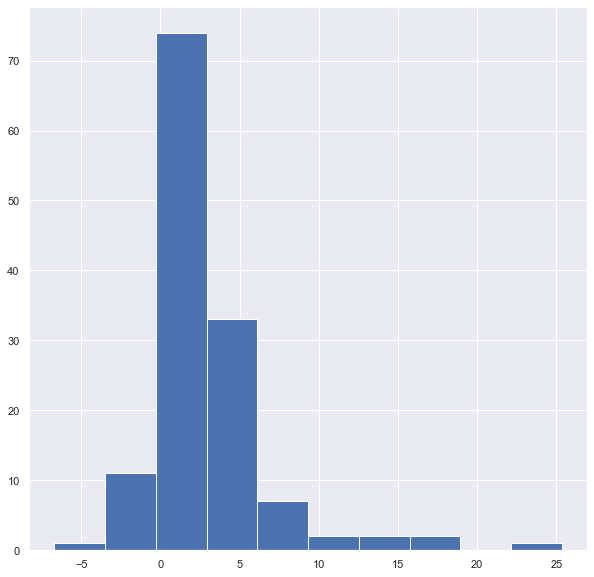

In [21]:
plt.figure(figsize=(10, 10))
plt.hist(snr_array_2[0][2])

в первом подходе выделяем трубку вдоль контура, все сложить и поделить на кол-во пикселей в этой трубочке, для шума также суммировать все и делить на сумму пикселей

2 стр

введение (есть морские животные крича, дельфины обладают разнообразной локализацией)
какие бывают алгоритмы обнаружения, для определения эффективности необходимо знать снр
нет универсального общепринятого способа опр-я снр нет
данные описание
рез-ты
вывод

скинуть пример где отрицательные значения снр
выложить код
текст!!